In [3]:
import numpy as np
from scipy.sparse import csc_array,csr_array,diags_array
from scipy.sparse import random_array
import matplotlib.pyplot as plt
from scipy.special import expit
from numpy import logaddexp
from tqdm.auto import tqdm
from scipy.optimize import minimize_scalar
from scipy.sparse.linalg import spsolve
import qdldl
from scipy.sparse import block_array,eye_array
import scipy
from sparse_dot_mkl import dot_product_mkl

In [4]:
class LogisticNLL:
    def __init__(self, y, w):
        """
        y: array-like of binary responses (0 or 1)
        w: array-like of corresponding weights
        """
        self.y = np.array(y, dtype=float)
        self.w = np.array(w, dtype=float)

    def f(self, z):
        """
        Computes the negative weighted logistic log-likelihood:
            sum_i w_i [ log(1 + exp(z_i)) - y_i * z_i ]
        """
        z = np.array(z, dtype=float)
        return np.sum(self.w * (logaddexp(0, z) - self.y * z))

    def d1f(self, z):
        """
        Computes the first derivative (gradient) w.r.t. z:
            w_i [ sigma(z_i) - y_i ]
        """
        z = np.array(z, dtype=float)
        sig_z = expit(z)
        return self.w * (sig_z - self.y)

    def d2f(self, z):
        """
        Computes the second derivative (Hessian diagonal) w.r.t. z:
            w_i * sigma(z_i) * (1 - sigma(z_i))
        also using expit(z) for numerical stability.
        """
        z = np.array(z, dtype=float)
        sig_z = expit(z)
        hess_diag = self.w * sig_z * (1.0 - sig_z)
        return hess_diag

    def __call__(self, z):
        """
        By defining __call__, this object can be used like a function:
            phi(z) = phi.f(z)
        """
        return self.f(z)

In [52]:
from scipy.stats import Uniform


m = 1000
n = 500
samp = Uniform(a = -0.5,b = 0.5).sample


A = random_array((m,n),density = 0.01,data_sampler = lambda size:samp(size))
x_true = np.random.uniform(-0.1,1,n)

z_true = A@x_true

w = 100*np.ones(m)
y = np.random.binomial(w.astype(int),expit(z_true))/w

Q = 1.*diags_array(np.ones(n))

rng = np.random.default_rng(10)

xx = rng.normal(size = n)
samp = Uniform(a = -0.5,b = 0.5).sample

C = random_array((200,n),
                 density = 0.2,rng = rng)



In [53]:
c = C@xx + 0.01
Q = 1e-7*diags_array(np.ones(n))
f = LogisticNLL(y,w)

In [54]:
def get_step_size(s, ds, y, dy,frac = 0.99):
    """
    Returns stepsize
      s + alpha*ds > 0  and  lam + alpha*dlam > 0
    for all components. with safety factor of frac
    """    
    # For s + alpha*ds > 0  =>  alpha < -s[i] / ds[i] for ds[i] < 0
    idx_s_neg = ds < 0
    if np.any(idx_s_neg):
        alpha_s = np.min(-s[idx_s_neg] / ds[idx_s_neg])
    else:
        alpha_s = np.inf  # If ds >= 0, it doesn't limit alpha
    
    # For y + alpha*dy > 0  =>  y < -y[i] / dy[i] for dy[i] < 0
    idx_y_neg = dy < 0
    if np.any(idx_y_neg):
        alpha_lam = np.min(-y[idx_y_neg] / dy[idx_y_neg])
    else:
        alpha_lam = np.inf
    
    alpha = min(frac*alpha_s, frac*alpha_lam, 1.0)
    return alpha


In [55]:
from dataclasses import dataclass

@dataclass
class SolverSettings():
    max_precenter = 100
    max_iter = 200
    tol = 1e-7
    boundary_frac = 0.99
    gamma = 0.5
    min_mu = 1e-10
    tau_reg =1e-12
    verbose = True


class GLMProblem():
    def __init__(
        self,
        f,A,Q,C,c,
        b=None,
        settings = None
        ):
        if settings is None:
            settings = SolverSettings()
        

        self.settings = settings
        
        m = A.shape[0]
        n = A.shape[1]
        assert A.shape[1] == C.shape[1]
        A = csc_array(A)

        #TODO:Separate solver dispatch for unconstrained
        assert C.shape[0] == len(c)
        C = csc_array(C)
        k = C.shape[0]
        self.k = k
        self.c = c

        if b is None:
            b = np.zeros(n)
        self.b = b
        
        
        if settings.verbose is True:
            print(f"{k} constraints")
            print(f"{n} variables")
            print(f"{m} rows in A")
        self.f = f
        self.A = A
        self.Q = Q
        self.C = C
        self.m = m
        self.n = n
        self.In = csc_array(eye_array(n))
        self.Ik = csc_array(eye_array(k))
    
    def initialize(self,x0=None,y0 = None,s0 = None):
        if x0 is None:
            x = np.zeros(self.n)
        else:
            x = np.copy(x0)
        
        if y0 is None:
            y = np.ones(self.k)
        else:
            y = np.copy(y0)
            assert np.min(y)>1e-8
        
        if s0 is None:
            s = np.maximum(self.c - self.C@x,0.01)
        else:
            s = np.copy(s0)
        
        return x,y,s
    
    def KKT_res(self,x,g,y,s,mu):
        rx = g + self.C.T@y - self.b
        rp = self.C@x + s - self.c
        rc = y * s - mu
        return rx,rp,rc
    
    def solve_KKT(
        self,
        x,y,s,H,rx,rp,rc,mu,#mu,x unused for now
        solver = None):
        #Nesterov-Todd scaling
        # Quasi definite for inequality constraints, 
        # "normal equations" Hessian for GLM part
        w = np.sqrt(y/s)
        wC = self.C.multiply(w[:,None])
        #Including tiny tau-shift here
        #later may want separate matrix,
        #larger tau shift + iterative refine
        G = block_array(
            [
                [H+self.settings.tau_reg*self.In,wC.T],
                [wC,-self.Ik]
            ],format = 'csc'
        )
        rhs = np.hstack([-rx,-w*rp + (w/y) * rc])
        if solver is None:
            solver = qdldl.Solver(G)
        else:
            solver.update(G)
        sol = solver.solve(rhs)
        # linres = rhs - G@sol
        dx = sol[:self.n]
        dy = w*sol[self.n:]
        ds = -rp - self.C@dx
        return dx,ds,dy,solver
    
    def get_H(self,z):
        D = self.f.d2f(z)[:,None]
        # use dot_product_mkl
        AtDa = dot_product_mkl(self.A.T,csc_array(self.A.multiply(D)))
        return AtDa + self.Q
    
    def solve(
        self,
        x0=None,
        y0=None,
        s0=None
        ):
        x,y,s = self.initialize(x0,y0,s0)
        settings = self.settings
        
        def merit_line(t,x,dx,mu):
            xt = x+t*dx
            return self.f(self.A@xt) + (1/2) * xt.T@self.Q@xt-mu*np.sum(np.log(c - C@(x+t*dx)))

        #Phase 1 to obtain feasibility
        # simple QP acts a precentering step
        z = self.A@x
        Hf = self.get_H(z)

        gradf = self.A.T@self.f.d1f(z)
        H = 0.001*np.mean(Hf.diagonal())*diags_array(np.ones(self.n)) + Hf

        mu = 10.
        solver = None

        for i in range(settings.max_precenter):
            #Gradient of the objective (without the b tilt)
            g = H@x + gradf
            rx,rp,rc = self.KKT_res(x,g,y,s,mu)
            kkt_res = np.max(
                np.abs(np.hstack([rx,rp,rc]))
            )
            primal_violation = np.max(np.abs(rp))
            print("Primal violation", primal_violation)
            print("Max KKT res:", kkt_res)
            print("Inequality violation:",np.min(c - self.C@x))
            print("New mu:",mu)
            print("______________________________")

            if (
                primal_violation<=1e-4 and 
                kkt_res<=1000 and
                (self.C@x + 1e-6<= self.c).all()
            ):
                break
            dx,ds,dy,solver = self.solve_KKT(x,y,s,H,rx,rp,rc,mu,solver)
            t = get_step_size(s,ds,y,dy,frac = settings.boundary_frac)
            x = x + t*dx
            s = s + t*ds
            y = y + t*dy
        print(f"Finished centering in {i} iterations")
    
        #Phase 2 to fit model
        for i in range(settings.max_iter):
            print("______________________________")
            print(f"Iteration {i}")
            z = self.A@x
            H = self.get_H(z)
            gradf = self.A.T@self.f.d1f(z) + self.Q@x
            rx,rp,rc = self.KKT_res(x,gradf,y,s,mu)
            kkt_res = np.max(
                np.abs(np.hstack([rx,rp,rc+ mu]))#broadcasted (+mu)
            )
            print("mu,KKTres", mu,kkt_res)
            if kkt_res<=settings.tol:
                break
            
            dx,ds,dy,solver = self.solve_KKT(x,y,s,H,rx,rp,rc,mu,solver)
            tmax = get_step_size(s,ds,y,dy,frac = settings.boundary_frac)
            m0 = merit_line(0.,x,dx,mu)
            t = tmax
            for i in range(10):
                mt = merit_line(t,x,dx,mu)
                if mt<m0:
                    break
                else:
                    t = 0.9*t
            print("t,merit_dec",t,mt - m0)
            x = x + t*dx
            s = s + t*ds
            y = y + t*dy

            if kkt_res<=100 * mu:
                mu_est = np.dot(s,y)/self.k
                xi = np.min(s*y)/mu_est
                mu = np.maximum(np.maximum(mu*0.01,settings.min_mu),settings.gamma * np.minimum(
                    (1-settings.boundary_frac)*(1-xi)/xi + 0.1,2
                )**3 * mu_est)
        return x


In [56]:
problem = GLMProblem(f,A,Q,C,c)

200 constraints
500 variables
1000 rows in A


In [57]:
x = problem.solve()

Primal violation 16.54245139960916
Max KKT res: 44.44131199935901
Inequality violation: -16.532451399609158
New mu: 10.0
______________________________
Primal violation 14.77777196070193
Max KKT res: 39.700498946392614
Inequality violation: -13.70483618607
New mu: 10.0
______________________________
Primal violation 11.63726426940459
Max KKT res: 31.263521936527013
Inequality violation: -9.43520545004854
New mu: 10.0
______________________________
Primal violation 6.35533753530647
Max KKT res: 17.073620556291054
Inequality violation: -3.1833723969391006
New mu: 10.0
______________________________
Primal violation 1.8974694291582264
Max KKT res: 9.713873411248656
Inequality violation: 3.001385661588671
New mu: 10.0
______________________________
Primal violation 5.46229728115577e-14
Max KKT res: 5.74311246475612
Inequality violation: 5.956447232916352
New mu: 10.0
______________________________
Finished centering in 5 iterations
______________________________
Iteration 0
mu,KKTres 10.0 

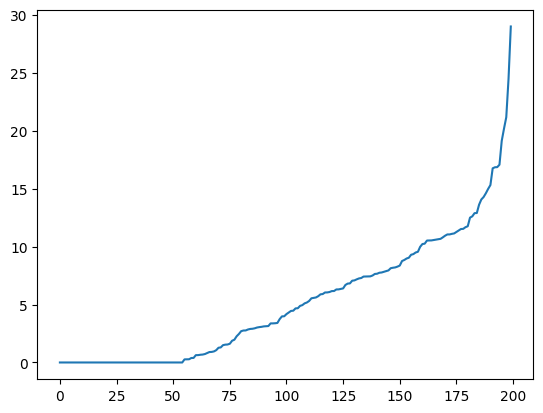

In [58]:
plt.plot(np.sort(c - C@x))

In [59]:
import cvxpy as cp
n = A.shape[1]

beta = cp.Variable(n)
lambd = cp.Parameter(nonneg=True)
neg_log_likelihood = cp.sum(
    cp.multiply(w,cp.logistic(A @ beta)- cp.multiply(y, A @ beta))
)
regularization = beta.T@Q@beta/2

problem  = cp.Problem(cp.Minimize(
    (neg_log_likelihood + regularization)),[C @ beta <= c]
)
problem.solve(verbose = True)

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) Apr 17 05:53:03 PM: Your problem has 500 variables, 200 constraints, and 0 parameters.
(CVXPY) Apr 17 05:53:03 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Apr 17 05:53:03 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Apr 17 05:53:03 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Apr 17 05:53:03 PM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Apr 17 05:53:03 PM: Compiling problem (target solver=CLARABEL

68598.6336017263

In [60]:
print(f(A@x) + (1/2) *x.T@Q@x)

cvx_x = beta.value
print(f(A@cvx_x) + (1/2) *cvx_x.T@Q@cvx_x)

68598.63359981633
68598.6336017263


In [51]:
cvx_x - x

array([ 1.00823119e-01,  5.47853468e-01, -1.07270931e+00, -2.75758559e-01,
       -7.28277625e-01,  2.19545879e-01, -1.04717948e+00,  1.62240654e+00,
       -6.81759054e-01,  5.18472591e-01,  9.08934254e-01, -2.14841688e+00,
       -9.84533710e-01, -8.35052554e-02, -1.49035632e+00, -4.36749497e-01,
       -1.33656688e+00, -1.89698942e+00,  1.76961982e-01,  5.03359153e-01,
       -1.47602841e-01, -7.12097232e-01,  8.61274107e-01,  6.68280540e-01,
       -1.28021614e+00, -2.41025185e-01, -2.50575745e+00, -7.91407616e-01,
       -1.95872272e+00,  3.05430050e-02,  1.15661129e+00, -1.68522653e-01,
        1.64497796e+00, -7.33330237e-01,  7.38375345e-02,  1.40922464e+00,
       -2.18384136e-01, -1.35091399e+00, -9.58179314e-01, -9.09925417e-01,
       -3.31675702e-01,  1.13200846e+00, -2.73940039e-01,  1.18482905e+00,
        9.42679026e-01,  4.83112113e-01, -6.38613189e-01,  1.26332096e+00,
       -1.40358644e+00, -2.29018496e+00,  3.57056273e-01, -4.53529530e-01,
        6.20313655e-01, -

In [177]:
print(problem.value -f(A@x) - (1/2) *x.T@Q@x)

-6.8239253430135705e-06
